---
title: "Lab 2, STAT 214 Spring 2025"
author: "Luna Kim, Connor Pestell, Zhaoyi Zhang, Kathy Li"
date: "3/21/2025"
execute:
    echo: False  
format:
  pdf:
    code-fold: true
    documentclass: scrartcl
    geometry: margin=1in
    code-overflow: wrap
    fontsize: 10pt
    header-includes:
      - \let\arrowvert\relax
      - \usepackage{graphicx}  # Ensures LaTeX can handle images
      - \usepackage{float}  # Helps control figure positioning
      - \usepackage{newtxtext,newtxmath}  % Sets Times New Roman-like fonts for text and math
      - \setlength{\parindent}{0em}
---

# 1 Introduction

Cloud detection in polar regions presents a significant scientific and statistical challenge due to the similar spectral and radiative properties shared by clouds and snow- or ice-covered surfaces. Accurate identification of clouds is critical for climate modeling, as clouds play a dual role in Earth's energy balance—contributing to warming by trapping heat and to cooling by reflecting sunlight. However, traditional cloud detection methods often struggle in the Arctic, where the low contrast between clouds and the surface in visible and infrared wavelengths limits their effectiveness.

In this lab, we develop a cloud detection algorithm using data from NASA’s Multi-angle Imaging SpectroRadiometer (MISR) onboard the Terra satellite. The primary goal is to build a predictive model that distinguishes cloud from non-cloud pixels in MISR imagery. MISR captures radiance from multiple viewing angles, providing valuable information about the vertical structure of the atmosphere. This multi-angle perspective aids cloud identification by leveraging altitude and scattering characteristics, rather than relying solely on brightness or temperature. Satellite imagery contributes to climate analysis through two key observations: different objects exhibit distinct radiative signatures (colors), and measurements taken closer to the Earth’s surface tend to reflect higher temperatures.

In addition to raw radiance data, we incorporate three engineered features—NDAI (Normalized Difference Angular Index), SD (Standard Deviation), and CORR (Correlation)—which are designed to enhance cloud detection accuracy. These features are informed by domain-specific knowledge and have demonstrated effectiveness in differentiating clouds from background surfaces.

This project is structured into several components: Exploratory Data Analysis (EDA), feature engineering, model selection, and model evaluation. Through these steps, we aim to explore the data, develop informative features, build robust models, and assess their predictive performance. We will also discuss the broader implications of our findings for climate science and highlight opportunities for future research.

# 2 Data

## 2.1  Data Collection and Description

The dataset used in this lab was collected from NASA’s Multi-angle Imaging SpectroRadiometer (MISR) onboard the Terra satellite. MISR captures satellite imagery in the red spectral band from nine different camera angles, which provides unique information about surface and atmospheric characteristics—especially helpful in distinguishing clouds from snow or ice in polar regions.

For this project, we worked with 164 image files in .npz format, each representing a different MISR scene. Every image contains pixel-level data across ten features, including spatial coordinates (X, Y), radiance values from five MISR angles (DF, CF, BF, AF, AN), and three engineered features: NDAI (Normalized Difference Angular Index), SD (Standard Deviation of radiance), and CORR (Correlation between angular radiances). These engineered features were developed by researchers based on domain expertise to enhance cloud detection performance in complex terrains.

Each pixel also includes a label indicating the presence or absence of a cloud: +1 for cloud, -1 for no cloud, and 0 for unlabeled pixels. However, only three images—O013257.npz, O013490.npz, and O012791.npz—contain expert-annotated labels, which we use as ground truth during our model development and evaluation phases. The remaining 161 images are unlabeled and serve as potential candidates for model inference after training.

This structured dataset allows us to explore how both raw radiance data and derived features can help distinguish clouds from background surfaces, while also reflecting the challenges of working with real-world satellite imagery that includes noise, class imbalance, and limited labeled data.

## 2.2 Data Cleaning

In [1]:
# Load necessery packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print(os.getcwd())

/Users/rurulala3265/Downloads/_Berkeley/_stat214/lab2/code


In [2]:
# Read the raw dataset
data_path = '/Users/rurulala3265/Downloads/_Berkeley/_stat214/stat-214/lab2/data/O002772.npz' # change it to your own path
# data_path = '~/stat-214/lab2/data/O002539.npz' # data path for my report

data = np.load(data_path)

# Check what arrays are inside
print(data.files)
print(data['arr_0']) 

['arr_0']
[[2.00000000e+00 6.60000000e+01 9.34292749e-02 ... 8.18966650e+03
  7.56800000e+03 7.43433350e+03]
 [2.00000000e+00 6.70000000e+01 1.57574058e-01 ... 9.47125000e+03
  8.54350000e+03 8.22650000e+03]
 [2.00000000e+00 6.80000000e+01 9.00644213e-02 ... 9.76350000e+03
  9.30575000e+03 8.86300000e+03]
 ...
 [3.83000000e+02 3.64000000e+02 1.35627165e-01 ... 2.84125000e+04
  2.65247500e+04 2.40602500e+04]
 [3.83000000e+02 3.65000000e+02 1.34893134e-01 ... 2.83665000e+04
  2.65050000e+04 2.40570000e+04]
 [3.83000000e+02 3.66000000e+02 1.34661451e-01 ... 2.83540000e+04
  2.65125000e+04 2.40205000e+04]]


In [3]:
data_dir = '/Users/rurulala3265/Downloads/_Berkeley/_stat214/stat-214/lab2/data/' # Full data file directorie
all_files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]

columns = [
    'Y', 'X', 'NDAI', 'SD', 'CORR',
    'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN', 'Label'
]

# Load all .npz files into one large DataFrame
all_data = []

for file in all_files:
    filepath = os.path.join(data_dir, file)
    npz_data = np.load(filepath)
    arr = npz_data['arr_0']
    
    # Handle short arrays (some may not have expert labels, only 10 columns)
    if arr.shape[1] == 10:
        temp_df = pd.DataFrame(arr, columns=columns[:-1])
        temp_df['Label'] = 0  # Assume unlabeled
    else:
        temp_df = pd.DataFrame(arr, columns=columns)
        
    temp_df['image_id'] = file  # Track source image
    all_data.append(temp_df)

# Concatenate everything
df_full = pd.concat(all_data, ignore_index=True)

In [4]:
print(df_full["Label"].value_counts())

Label
 0.0    18726948
-1.0      126716
 1.0       80965
Name: count, dtype: int64


In [5]:
print(df_full.isna().sum()) # no NA's
print(df_full.describe())
print(df_full.shape)

Y              0
X              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
Label          0
image_id       0
dtype: int64
                  Y             X          NDAI            SD          CORR  \
count  1.893463e+07  1.893463e+07  1.893463e+07  1.893463e+07  1.893463e+07   
mean   1.930251e+02  2.169185e+02  2.004957e-01  5.754315e+02  5.079496e-01   
std    1.102642e+02  8.727746e+01  1.035793e-01  7.059685e+02  3.863470e-01   
min    2.000000e+00  5.700000e+01 -6.123912e-01  5.656854e+00 -9.765562e-01   
25%    9.800000e+01  1.410000e+02  1.294750e-01  9.699843e+01  2.103757e-01   
50%    1.930000e+02  2.170000e+02  1.713340e-01  3.335365e+02  5.997756e-01   
75%    2.890000e+02  2.920000e+02  2.513019e-01  7.590168e+02  8.546392e-01   
max    3.830000e+02  3.730000e+02  9.374210e-01  9.729683e+03  9.840799e-01   

        Radiance_DF   Radiance_CF   Radiance_BF   Radiance_AF   Radianc

In [6]:
# Filter out unlabeled if you only want labeled data
df_labeled = df_full[df_full['Label'] != 0].copy()
print('Final Labeled dataFrame shape: ', df_labeled.shape)

Final Labeled dataFrame shape:  (207681, 12)


In [7]:
# Normalize features (we n)
from sklearn.preprocessing import StandardScaler

# Remove outliers in NDAI
df_labeled = df_labeled[(df_labeled['NDAI'] >= -1) & (df_labeled['NDAI'] <= 1)]

# Remove invalid SD values only
df_labeled = df_labeled[df_labeled['SD'] >= 0]

features = ['NDAI', 'SD', 'CORR', 'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']
scaler = StandardScaler()
df_labeled[features] = scaler.fit_transform(df_labeled[features])

print('Final Labeled dataFrame shape: ', df_labeled.shape)


Final Labeled dataFrame shape:  (207681, 12)


In [8]:
print("===== After Data cleaning =====")
print(df_labeled["image_id"].unique())

===== After Data cleaning =====
['O012791.npz' 'O013257.npz' 'O013490.npz']


# 3 EDA and Split Train/Test dataset

## 3.2 EDA

In [19]:
labeled_files = ['O013257.npz', 'O013490.npz', 'O012791.npz']

columns = [
    'Y', 'X', 'NDAI', 'SD', 'CORR',
    'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN', 'Label'
]

dfs = []
for file in labeled_files:
    path = os.path.join(data_dir, file)
    data = np.load(path)['arr_0']
    df = pd.DataFrame(data, columns=columns)
    df['image_id'] = file
    dfs.append(df)

df_3images = pd.concat(dfs, ignore_index=True)
df_3images_labeled = df_3images[df_3images['Label'] != 0].copy()

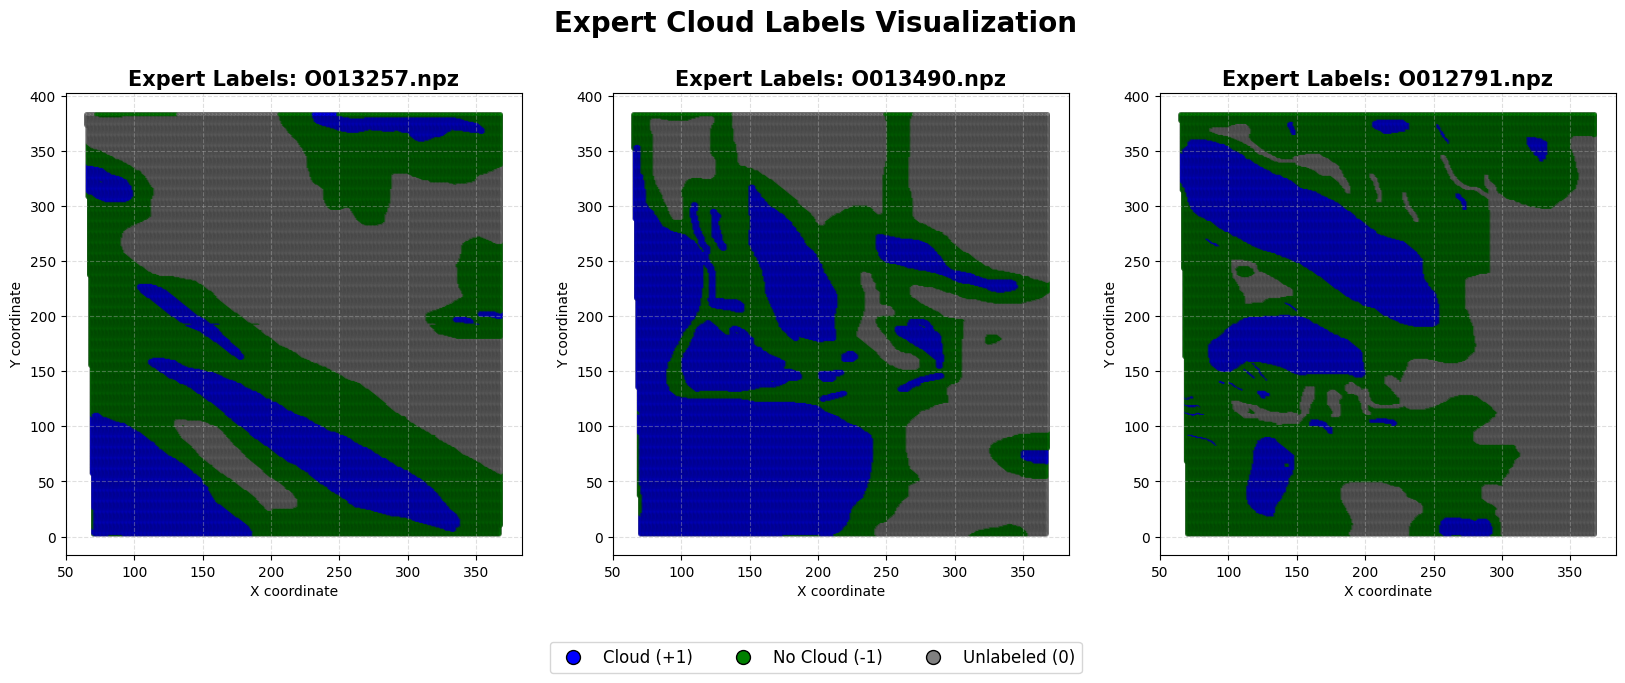

In [20]:
# ===== Plot of Expert Labels on a Map =====
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

label_colors = ListedColormap(['gray', 'green', 'blue'])  # -1: green (No Cloud), 0: gray (Unlabeled), +1: blue (Cloud)
label_names = {-1: 'No Cloud', 0: 'Unlabeled', 1: 'Cloud'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, file in enumerate(labeled_files):
    ax = axes[i]
    df = df_3images[df_3images['image_id'] == file]
    scatter = ax.scatter(
        df['X'], df['Y'], c=df['Label'], cmap=label_colors,
        s=8, alpha=0.7, edgecolors='black', linewidths=0.2
    )
    ax.set_title(f"Expert Labels: {file}", fontsize=15, fontweight='bold')
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.grid(True, linestyle='--', alpha=0.4)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cloud (+1)', markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='No Cloud (-1)', markerfacecolor='green', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Unlabeled (0)', markerfacecolor='gray', markersize=10, markeredgecolor='k')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, fontsize=12, frameon=True)
plt.suptitle("Expert Cloud Labels Visualization", fontsize=20, fontweight='bold', y=1.02)
plt.show()

The spatial visualizations of expert-labeled cloud masks across the three images (O013257, O013490, and O012791) show clear patterns in how clouds and non-cloud regions are distributed. Cloud-labeled pixels (+1) and no-cloud pixels (-1) appear in distinct clusters, often aligned along certain altitudes or terrain features, while unlabeled areas (0) typically form the background. These plots demonstrate that spatial information (X, Y) may be useful for modeling local patterns, but more importantly, they reveal that clouds and no-cloud areas often occur in separate, structured regions, supporting the feasibility of spatially aware classification methods.

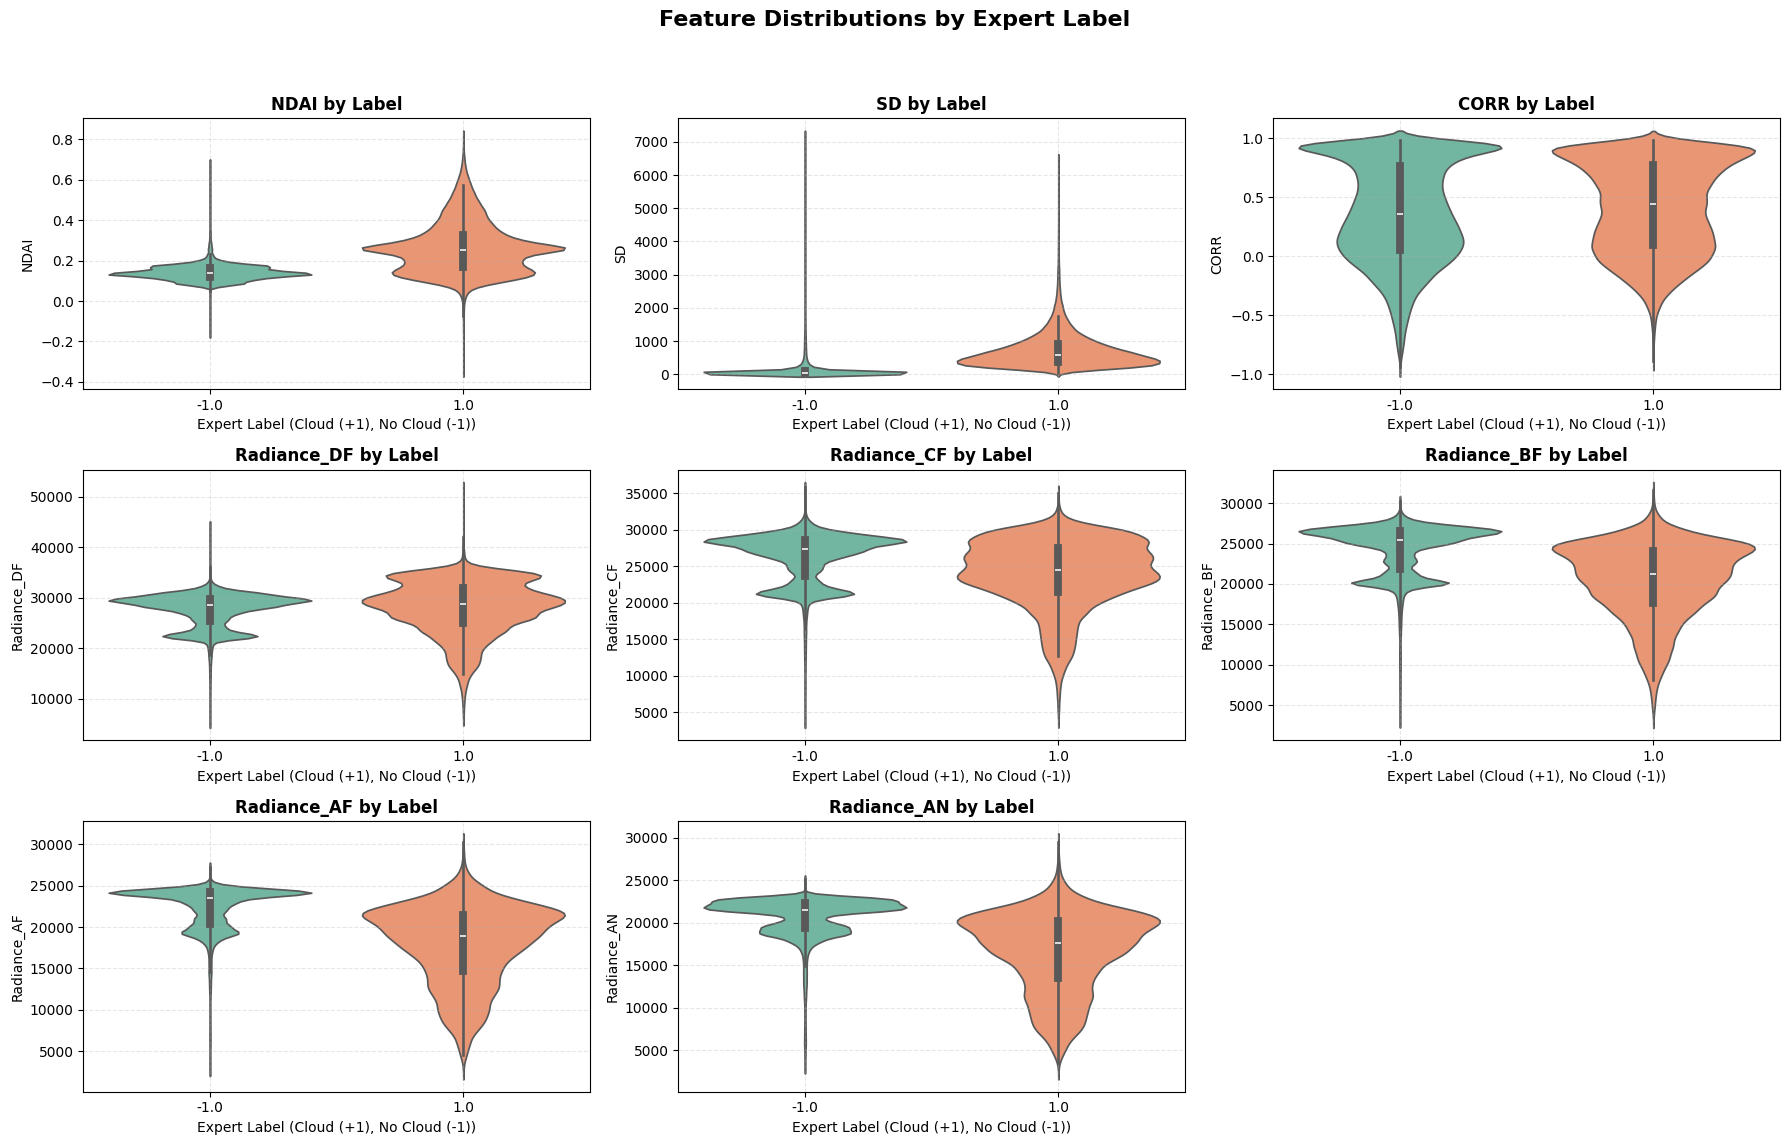

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== Radiance and Feature Relationship Analysis =====
features_to_plot = ['NDAI', 'SD', 'CORR', 'Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    sns.violinplot(ax=axes[idx], data=df_3images_labeled, x='Label', y=feature, inner='box', palette='Set2')
    axes[idx].set_title(f"{feature} by Label", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Expert Label (Cloud (+1), No Cloud (-1))")
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, linestyle='--', alpha=0.3)

for i in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Feature Distributions by Expert Label", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The violin plots comparing feature distributions across cloud and no-cloud classes provide deeper insight into the relationships between radiance and cloud presence. NDAI shows clear class separation—values are generally higher for cloud pixels, indicating its effectiveness as a discriminative feature. Similarly, SD and CORR distributions show meaningful differences, although SD is more skewed and may require normalization. Radiance values across the MISR angles also differ between classes; in particular, cloud pixels tend to have higher or more variable radiance across multiple angles, suggesting that the angular scattering properties captured by MISR are indeed informative. These plots confirm that multiple features—not just one—carry useful signal for separating clouds from background.

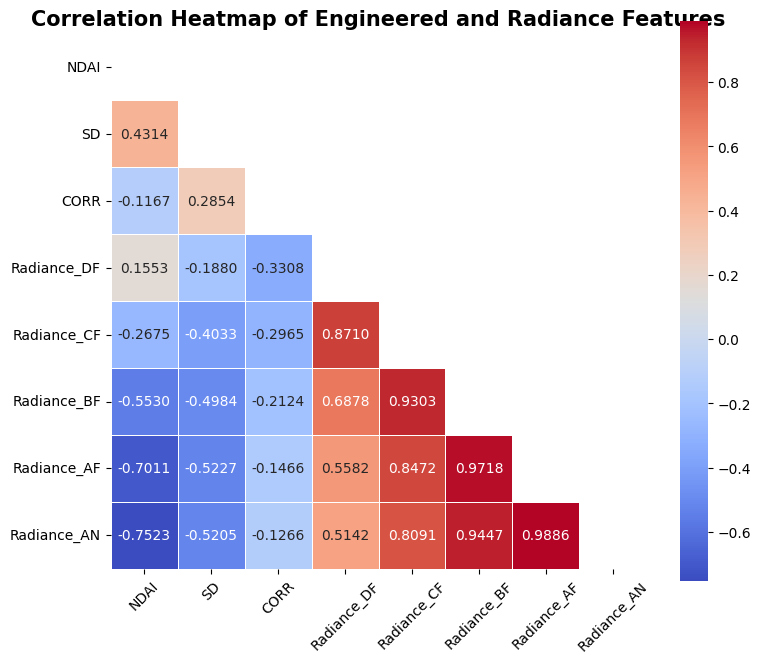

In [22]:
# ===== Correlation Heatmap ===== 
numeric_df = df_3images_labeled.select_dtypes(include='number').drop(columns=['X', 'Y', 'Label'])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(8, 8))
sns.heatmap(correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".4f",
            square=True, linewidths=0.6, cbar_kws={"shrink": 0.75}, annot_kws={"size":10})
plt.title("Correlation Heatmap of Engineered and Radiance Features", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

While radiance values across different angles are strongly correlated with each other (especially among BF, AF, and AN), engineered features like NDAI and CORR show weaker correlations with raw radiance. This indicates that NDAI, SD, and CORR introduce additional, non-redundant information to the model. Interestingly, NDAI is negatively correlated with most radiance features, reflecting how the angular differences contribute to its calculation. These relationships highlight that while radiance angles provide foundational data, the engineered features derived from domain knowledge offer complementary and potentially more robust signals for classification. This blend of features enhances model interpretability and improves chances for generalization to unlabeled scenes.

## 3.2 Split Train/Test dataset

In [ ]:
# ===== Data Split =====
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df_3images, test_size=0.3, stratify=df_3images_labeled['Label'], random_state=214)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=214)

print("===== Data Split =====")
print(f"Training size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Validation size: {len(val_df)}")

===== Data Split =====
Training size: 145376
Test size: 31153
Validation size: 31152


Splitting the data into training (70%), validation (15%), and test (15%) sets reflects a practical modeling pipeline.
#The training set allows the model to learn a general pattern, while the validation set helps in tuning hyperparameters and preventing overfitting. The independent test set evaluates the final model performance on unseen data. Stratified sampling ensures both cloud and no-cloud classes are well represented in each split, which is crucial given the class imbalance challenge in real-world cloud detection scenarios. This structure also mirrors future applications, where a trained model needs to generalize well to unseen satellite imagery with varying cloud coverage conditions.